# Transfer predictions from NAGuideR


In [1]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import pimmslearn
import pimmslearn.models
import pimmslearn.pandas
from pimmslearn.io import datasplits

pimmslearn.plotting.make_large_descriptors(5)

logger = pimmslearn.logging.setup_logger(logging.getLogger('pimmslearn'))

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (csv)
identifer_str: str = '_all_'  # identifier for prediction files to be filtered
dumps: list = None  # list of dumps to be used

In [4]:
# Parameters
dumps = "runs/alzheimer_study/preds/pred_all_BPCA.csv,runs/alzheimer_study/preds/pred_all_COLMEDIAN.csv,runs/alzheimer_study/preds/pred_all_IMPSEQ.csv,runs/alzheimer_study/preds/pred_all_IMPSEQROB.csv,runs/alzheimer_study/preds/pred_all_IRM.csv,runs/alzheimer_study/preds/pred_all_KNN_IMPUTE.csv,runs/alzheimer_study/preds/pred_all_LLS.csv,runs/alzheimer_study/preds/pred_all_MINDET.csv,runs/alzheimer_study/preds/pred_all_MINIMUM.csv,runs/alzheimer_study/preds/pred_all_MINPROB.csv,runs/alzheimer_study/preds/pred_all_MLE.csv,runs/alzheimer_study/preds/pred_all_PI.csv,runs/alzheimer_study/preds/pred_all_QRILC.csv,runs/alzheimer_study/preds/pred_all_RF.csv,runs/alzheimer_study/preds/pred_all_ROWMEDIAN.csv,runs/alzheimer_study/preds/pred_all_SVDMETHOD.csv,runs/alzheimer_study/preds/pred_all_TRKNN.csv,runs/alzheimer_study/preds/pred_all_ZERO.csv"
folder_experiment = "runs/alzheimer_study"


Some argument transformations

In [5]:
args = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.args_from_dict(args)
args

{'data': Path('runs/alzheimer_study/data'),
 'dumps': 'runs/alzheimer_study/preds/pred_all_BPCA.csv,runs/alzheimer_study/preds/pred_all_COLMEDIAN.csv,runs/alzheimer_study/preds/pred_all_IMPSEQ.csv,runs/alzheimer_study/preds/pred_all_IMPSEQROB.csv,runs/alzheimer_study/preds/pred_all_IRM.csv,runs/alzheimer_study/preds/pred_all_KNN_IMPUTE.csv,runs/alzheimer_study/preds/pred_all_LLS.csv,runs/alzheimer_study/preds/pred_all_MINDET.csv,runs/alzheimer_study/preds/pred_all_MINIMUM.csv,runs/alzheimer_study/preds/pred_all_MINPROB.csv,runs/alzheimer_study/preds/pred_all_MLE.csv,runs/alzheimer_study/preds/pred_all_PI.csv,runs/alzheimer_study/preds/pred_all_QRILC.csv,runs/alzheimer_study/preds/pred_all_RF.csv,runs/alzheimer_study/preds/pred_all_ROWMEDIAN.csv,runs/alzheimer_study/preds/pred_all_SVDMETHOD.csv,runs/alzheimer_study/preds/pred_all_TRKNN.csv,runs/alzheimer_study/preds/pred_all_ZERO.csv',
 'file_format': 'csv',
 'folder_data': '',
 'folder_experiment': Path('runs/alzheimer_study'),
 'ident

In [6]:
files_out = {}

load data splits

In [7]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Validation and test data split of simulated missing values

In [8]:
val_pred_fake_na = data.val_y.to_frame(name='observed')
val_pred_fake_na

,,observed
Sample ID,protein groups,
Sample_158,Q9UN70;Q9UN70-2,14.630
Sample_050,Q9Y287,15.755
Sample_107,Q8N475;Q8N475-2,15.029
Sample_199,P06307,19.376
Sample_067,Q5VUB5,15.309
...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822
Sample_002,A0A0A0MT36,18.165
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525


In [9]:
test_pred_fake_na = data.test_y.to_frame(name='observed')
test_pred_fake_na.describe()

,observed
count,"12,600.000"
mean,16.339
std,2.741
min,7.209
25%,14.412
50%,15.935
75%,17.910
max,30.140


In [10]:
# Find and load prediction files, filter for validation and test data

In [11]:
if args.dumps is not None:
    entire_pred = [Path(s) for s in args.dumps.split(',')]
else:
    entire_pred = list(file for file in args.out_preds.iterdir()
                       if '_all_' in str(file))
entire_pred

[Path('runs/alzheimer_study/preds/pred_all_BPCA.csv'),
 Path('runs/alzheimer_study/preds/pred_all_COLMEDIAN.csv'),
 Path('runs/alzheimer_study/preds/pred_all_IMPSEQ.csv'),
 Path('runs/alzheimer_study/preds/pred_all_IMPSEQROB.csv'),
 Path('runs/alzheimer_study/preds/pred_all_IRM.csv'),
 Path('runs/alzheimer_study/preds/pred_all_KNN_IMPUTE.csv'),
 Path('runs/alzheimer_study/preds/pred_all_LLS.csv'),
 Path('runs/alzheimer_study/preds/pred_all_MINDET.csv'),
 Path('runs/alzheimer_study/preds/pred_all_MINIMUM.csv'),
 Path('runs/alzheimer_study/preds/pred_all_MINPROB.csv'),
 Path('runs/alzheimer_study/preds/pred_all_MLE.csv'),
 Path('runs/alzheimer_study/preds/pred_all_PI.csv'),
 Path('runs/alzheimer_study/preds/pred_all_QRILC.csv'),
 Path('runs/alzheimer_study/preds/pred_all_RF.csv'),
 Path('runs/alzheimer_study/preds/pred_all_ROWMEDIAN.csv'),
 Path('runs/alzheimer_study/preds/pred_all_SVDMETHOD.csv'),
 Path('runs/alzheimer_study/preds/pred_all_TRKNN.csv'),
 Path('runs/alzheimer_study/preds/

In [12]:
mask = data.train_X.unstack().isna().stack()
idx_real_na = mask.index[mask]
idx_real_na = (idx_real_na
               .drop(val_pred_fake_na.index)
               .drop(test_pred_fake_na.index))

for fpath in entire_pred:
    logger.info(f"Load {fpath = }")
    col_name = fpath.stem.split('_all_')[-1]
    pred = pd.read_csv(fpath, index_col=[1, 0])
    val_pred_fake_na[col_name] = pred
    fname = args.out_preds / f'pred_val_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    val_pred_fake_na[['observed', col_name]].to_csv(fname)
    logger.info(f"Save {fname = }")

    test_pred_fake_na[col_name] = pred
    fname = args.out_preds / f'pred_test_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    test_pred_fake_na[['observed', col_name]].to_csv(fname)
    logger.info(f"Save {fname = }")
    # hacky, but works:
    pred_real_na = (pd.Series(0, index=idx_real_na, name='placeholder')
                    .to_frame()
                    .join(pred, how='left')
                    .drop('placeholder', axis=1))
    # pred_real_na.name = 'intensity'
    fname = args.out_preds / f'pred_real_na_{col_name}.csv'
    files_out[fname.name] = fname.as_posix()
    pred_real_na.to_csv(fname)
    logger.info(f"Save {fname = }")

# del pred

pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_BPCA.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_BPCA.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_BPCA.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_BPCA.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_COLMEDIAN.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_COLMEDIAN.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_COLMEDIAN.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_COLMEDIAN.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_IMPSEQ.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_IMPSEQ.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_IMPSEQ.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_IMPSEQ.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_IMPSEQROB.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_IMPSEQROB.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_IMPSEQROB.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_IMPSEQROB.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_IRM.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_IRM.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_IRM.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_IRM.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_KNN_IMPUTE.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_KNN_IMPUTE.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_KNN_IMPUTE.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_KNN_IMPUTE.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_LLS.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_LLS.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_LLS.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_LLS.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_MINDET.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_MINDET.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_MINDET.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_MINDET.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_MINIMUM.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_MINIMUM.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_MINIMUM.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_MINIMUM.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_MINPROB.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_MINPROB.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_MINPROB.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_MINPROB.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_MLE.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_MLE.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_MLE.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_MLE.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_PI.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_PI.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_PI.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_PI.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_QRILC.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_QRILC.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_QRILC.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_QRILC.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_RF.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_RF.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_RF.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_RF.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_ROWMEDIAN.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_ROWMEDIAN.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_ROWMEDIAN.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_ROWMEDIAN.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_SVDMETHOD.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_SVDMETHOD.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_SVDMETHOD.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_SVDMETHOD.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_TRKNN.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_TRKNN.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_TRKNN.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_TRKNN.csv')


pimmslearn - INFO     Load fpath = Path('runs/alzheimer_study/preds/pred_all_ZERO.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_val_ZERO.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_test_ZERO.csv')


pimmslearn - INFO     Save fname = Path('runs/alzheimer_study/preds/pred_real_na_ZERO.csv')


In [13]:
val_pred_fake_na

,,observed,BPCA,COLMEDIAN,IMPSEQ,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO
Sample ID,protein groups,,,,,,,,,,,,,,,,,,,
Sample_158,Q9UN70;Q9UN70-2,14.630,15.469,16.800,NaN,NaN,15.871,15.937,15.858,11.916,7.068,11.889,"2,513.638",12.411,14.663,15.553,15.752,17.206,15.700,0
Sample_050,Q9Y287,15.755,16.453,17.288,NaN,16.106,17.472,16.961,17.058,12.900,7.068,12.857,19.829,11.833,15.475,17.299,17.221,17.807,16.738,0
Sample_107,Q8N475;Q8N475-2,15.029,13.110,17.187,NaN,"2,582.130",12.680,15.437,14.397,12.313,7.068,12.817,"2,582.130",10.481,13.516,14.327,14.846,17.434,13.776,0
Sample_199,P06307,19.376,19.639,16.711,NaN,NaN,19.632,18.861,19.005,12.285,7.068,12.386,"2,483.120",12.640,17.145,19.099,18.973,17.111,19.015,0
Sample_067,Q5VUB5,15.309,15.465,16.743,NaN,NaN,15.976,15.079,15.104,11.827,7.068,11.732,"2,569.564",12.763,13.289,14.906,14.726,17.031,14.699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822,22.994,17.042,NaN,"2,634.108",22.983,22.837,22.836,12.161,7.068,12.084,"2,634.108",9.981,21.877,22.898,22.918,17.330,22.872,0
Sample_002,A0A0A0MT36,18.165,15.882,16.792,NaN,NaN,17.237,15.446,15.579,12.586,7.068,12.638,"2,448.503",12.434,13.236,15.948,15.877,16.879,15.671,0
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525,15.406,17.032,NaN,"2,487.550",15.313,15.995,15.903,12.352,7.068,12.398,"2,487.550",12.603,14.833,15.649,16.278,17.215,15.574,0


Metrics for simulated missing values (NA)

In [14]:
# papermill_description=metrics
d_metrics = pimmslearn.models.Metrics()

In [15]:
added_metrics = d_metrics.add_metrics(val_pred_fake_na.dropna(how='all', axis=1), 'valid_fake_na')
pd.DataFrame(added_metrics)

Selected as truth to compare to: observed


,BPCA,COLMEDIAN,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO
MSE,0.388,7.712,"6,179,879.361",0.709,0.702,108.639,25.619,97.284,26.167,"5,393,471.689",23.195,4.399,0.453,0.695,8.040,0.426,281.082
MAE,0.406,2.204,"2,433.435",0.575,0.535,0.695,4.267,9.468,4.302,"2,132.119",3.977,1.635,0.448,0.580,2.283,0.436,16.536
N,"2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000","2,892.000"
prop,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Test Datasplit

In [16]:
added_metrics = d_metrics.add_metrics(test_pred_fake_na.dropna(how='all', axis=1), 'test_fake_na')
pd.DataFrame(added_metrics)

Selected as truth to compare to: observed


,BPCA,COLMEDIAN,IMPSEQROB,IRM,KNN_IMPUTE,LLS,MINDET,MINIMUM,MINPROB,MLE,PI,QRILC,RF,ROWMEDIAN,SVDMETHOD,TRKNN,ZERO
MSE,0.557,7.941,"6,227,545.432",0.834,0.870,0.688,24.975,95.562,25.306,"5,505,296.129",22.812,4.370,0.570,0.843,8.370,0.562,277.956
MAE,0.453,2.217,"2,451.991",0.597,0.578,0.524,4.190,9.369,4.203,"2,175.538",3.921,1.627,0.480,0.624,2.314,0.470,16.437
N,"2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000","2,976.000"
prop,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [17]:
metrics_df = pimmslearn.models.get_df_from_nested_dict(
    d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset                 valid_fake_na  test_fake_na
model     metric_name                             
BPCA      MSE                  0.388         0.557
          MAE                  0.406         0.453
          N                2,892.000     2,976.000
          prop                 1.000         1.000
COLMEDIAN MSE                  7.712         7.941
...                              ...           ...
TRKNN     prop                 1.000         1.000
ZERO      MSE                281.082       277.956
          MAE                 16.536        16.437
          N                2,892.000     2,976.000
          prop                 1.000         1.000

[68 rows x 2 columns]

In [18]:
order_methods = metrics_df.loc[pd.IndexSlice[:,
                                             'MAE'], 'valid_fake_na'].sort_values()
order_methods

model       metric_name
BPCA        MAE               0.406
TRKNN       MAE               0.436
RF          MAE               0.448
KNN_IMPUTE  MAE               0.535
IRM         MAE               0.575
ROWMEDIAN   MAE               0.580
LLS         MAE               0.695
QRILC       MAE               1.635
COLMEDIAN   MAE               2.204
SVDMETHOD   MAE               2.283
PI          MAE               3.977
MINDET      MAE               4.267
MINPROB     MAE               4.302
MINIMUM     MAE               9.468
ZERO        MAE              16.536
MLE         MAE           2,132.119
IMPSEQROB   MAE           2,433.435
Name: valid_fake_na, dtype: float64

In [19]:
top_5 = ['observed', *order_methods.droplevel(-1).index[:6]]
top_5

['observed', 'BPCA', 'TRKNN', 'RF', 'KNN_IMPUTE', 'IRM', 'ROWMEDIAN']

/home/runner/work/pimms/pimms/project/.snakemake/conda/924ec7e362d761ecf0807b9074d79999_/lib/python3.12/site-packages/pimmslearn/plotting/errors.py:45: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  ax = sns.barplot(data=errors_binned, ax=ax,


pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/NAGuideR_errors_per_bin_val.png


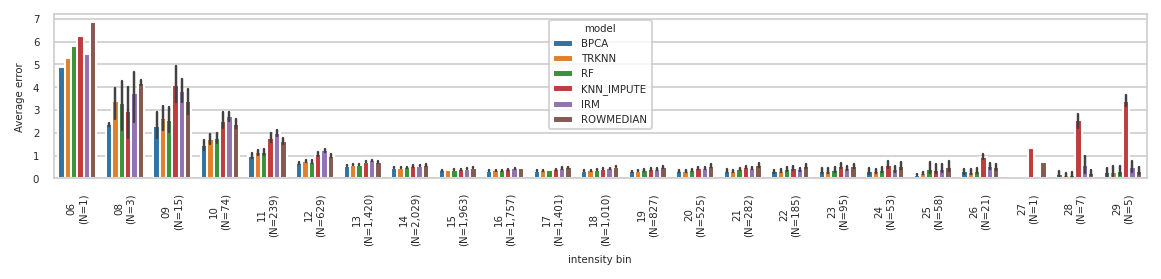

In [20]:
fig, ax = plt.subplots(figsize=(8, 2))
ax, errors_bind = pimmslearn.plotting.errors.plot_errors_binned(
    val_pred_fake_na[top_5],
    ax=ax,
)
fname = args.out_figures / 'NAGuideR_errors_per_bin_val.png'
files_out[fname.name] = fname.as_posix()
pimmslearn.savefig(ax.get_figure(), fname)

In [21]:
files_out

{'pred_val_BPCA.csv': 'runs/alzheimer_study/preds/pred_val_BPCA.csv',
 'pred_test_BPCA.csv': 'runs/alzheimer_study/preds/pred_test_BPCA.csv',
 'pred_real_na_BPCA.csv': 'runs/alzheimer_study/preds/pred_real_na_BPCA.csv',
 'pred_val_COLMEDIAN.csv': 'runs/alzheimer_study/preds/pred_val_COLMEDIAN.csv',
 'pred_test_COLMEDIAN.csv': 'runs/alzheimer_study/preds/pred_test_COLMEDIAN.csv',
 'pred_real_na_COLMEDIAN.csv': 'runs/alzheimer_study/preds/pred_real_na_COLMEDIAN.csv',
 'pred_val_IMPSEQ.csv': 'runs/alzheimer_study/preds/pred_val_IMPSEQ.csv',
 'pred_test_IMPSEQ.csv': 'runs/alzheimer_study/preds/pred_test_IMPSEQ.csv',
 'pred_real_na_IMPSEQ.csv': 'runs/alzheimer_study/preds/pred_real_na_IMPSEQ.csv',
 'pred_val_IMPSEQROB.csv': 'runs/alzheimer_study/preds/pred_val_IMPSEQROB.csv',
 'pred_test_IMPSEQROB.csv': 'runs/alzheimer_study/preds/pred_test_IMPSEQROB.csv',
 'pred_real_na_IMPSEQROB.csv': 'runs/alzheimer_study/preds/pred_real_na_IMPSEQROB.csv',
 'pred_val_IRM.csv': 'runs/alzheimer_study/preds